# Advanced Econometrics (JEM217)– Home Assignment 1 (WS 2025)



**AI Usage**

ChatGPT-5 was used during the preparation of this assignment **solely for grammatical editing and minor code optimization**.  
Any sections where AI-assisted code optimization was applied are explicitly indicated within the notebook.

## Initial Preparation

In this section, we install and load all required R packages necessary for data simulation, estimation, and visualization.  
We also set a fixed random seed (`set.seed(123)`) to ensure that all simulated results are fully reproducible.


In [6]:

req_pkgs <- c("ggplot2","dplyr","quantreg","lmtest","sandwich","car","stargazer","knitr","glm2")
for (p in req_pkgs) {
  if (!requireNamespace(p, quietly = TRUE)) {
    install.packages(p, repos = "https://cloud.r-project.org")
  }
}
library(ggplot2)
library(dplyr)
library(quantreg)
library(lmtest)
library(sandwich)
library(car)
library(stargazer)
library(knitr)
library(glm2)

set.seed(123) 


Installing package into 'C:/Users/fazol/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'glm2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\fazol\AppData\Local\Temp\Rtmpori02v\downloaded_packages


Warning message:
"package 'dplyr' was built under R version 4.4.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'quantreg' was built under R version 4.4.3"
Loading required package: SparseM

Warning message:
"package 'SparseM' was built under R version 4.4.3"
Warning message:
"package 'lmtest' was built under R version 4.4.3"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 4.4.3"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Warning message:
"package 'sandwich' was built under R version 4.4.3"
Warning message:
"package 'car' was built under R version 4.4.3"
Loading required package: carData

Warning message:
"package 'carData' was built under R version 4.4.3"

Attaching package: 'car'


The following

## Problem 1: Simulating Used Car Prices 
### 1) Data Simulation

We simulated according to the data‑generating process described in the assignment:
$
\text{price}_i = 1000 - 0.0005\,\text{milage}_i^2 - 5\,\text{years\_old}_i + 50\,\text{convertible}_i + 100\,\text{luxury}_i + \varepsilon_i,\quad \varepsilon_i\sim\mathcal{N}(0,15).
$

We also build a `data.frame` called `cars`.

We chose relatively small sample size 200 to obtain "interesting results" as was mentioned in the assignment.

In [ ]:

N <- 200

# Explanatory variables (X)
milage      <- rnorm(N, mean = 1000, sd = 300)
years_old   <- sample(2:15, N, replace = TRUE)
convertible <- rbinom(N, 1, 0.3)
luxury      <- rbinom(N, 1, 0.2)

# Error term
epsilon <- rnorm(N, mean = 0, sd = 15)

# Outcome
price <- 1000 - 0.0005 * milage^2 - 5 * years_old + 50 * convertible + 100 * luxury + epsilon

cars <- data.frame(price, milage, years_old, convertible, luxury)

# Peek
head(cars)


,price,milage,years_old,convertible,luxury
,<dbl>,<dbl>,<int>,<int>,<int>
1,652.9847,831.8573,8,1,0
2,594.6920,930.9468,4,1,0
3,-122.2930,1467.6125,10,0,0
4,443.0286,1021.1525,14,1,0
5,417.6969,1038.7863,8,0,0
6,-207.3756,1514.5195,15,0,0


### 1a) Descriptive Statistics & Figures

We report summary statistics, a scatterplot matrix, and selected plots. The values are expected.


     price            milage         years_old      convertible  
 Min.   :-987.8   Min.   : 307.2   Min.   : 2.00   Min.   :0.00  
 1st Qu.: 295.6   1st Qu.: 812.3   1st Qu.: 5.00   1st Qu.:0.00  
 Median : 476.1   Median : 982.4   Median : 9.00   Median :0.00  
 Mean   : 449.8   Mean   : 997.4   Mean   : 8.64   Mean   :0.29  
 3rd Qu.: 663.6   3rd Qu.:1170.5   3rd Qu.:12.00   3rd Qu.:1.00  
 Max.   :1022.9   Max.   :1972.3   Max.   :15.00   Max.   :1.00  
     luxury    
 Min.   :0.00  
 1st Qu.:0.00  
 Median :0.00  
 Mean   :0.17  
 3rd Qu.:0.00  
 Max.   :1.00  

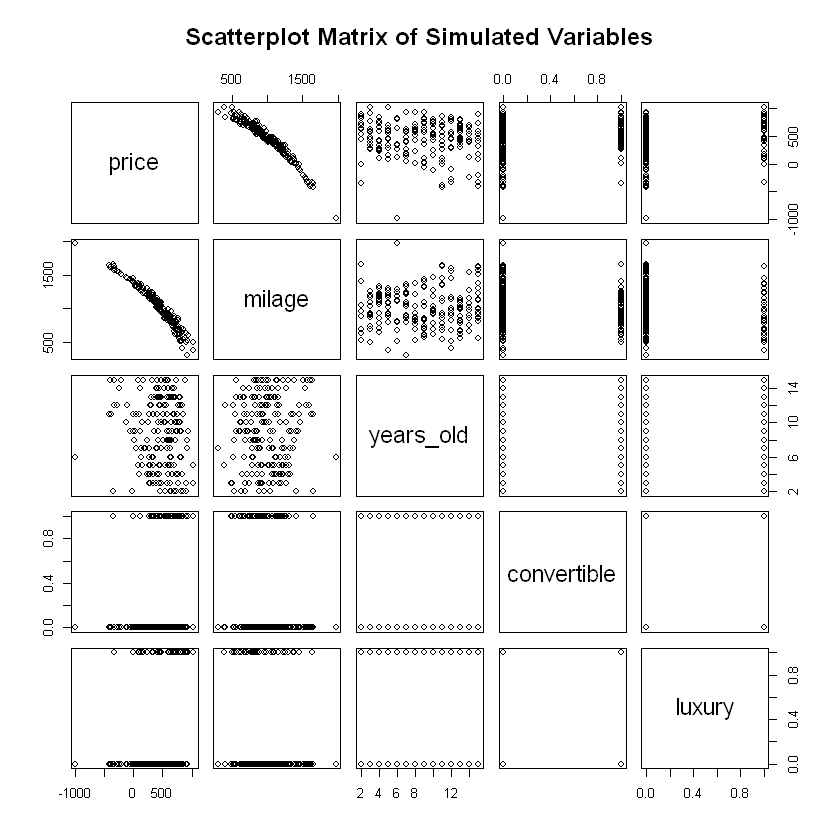

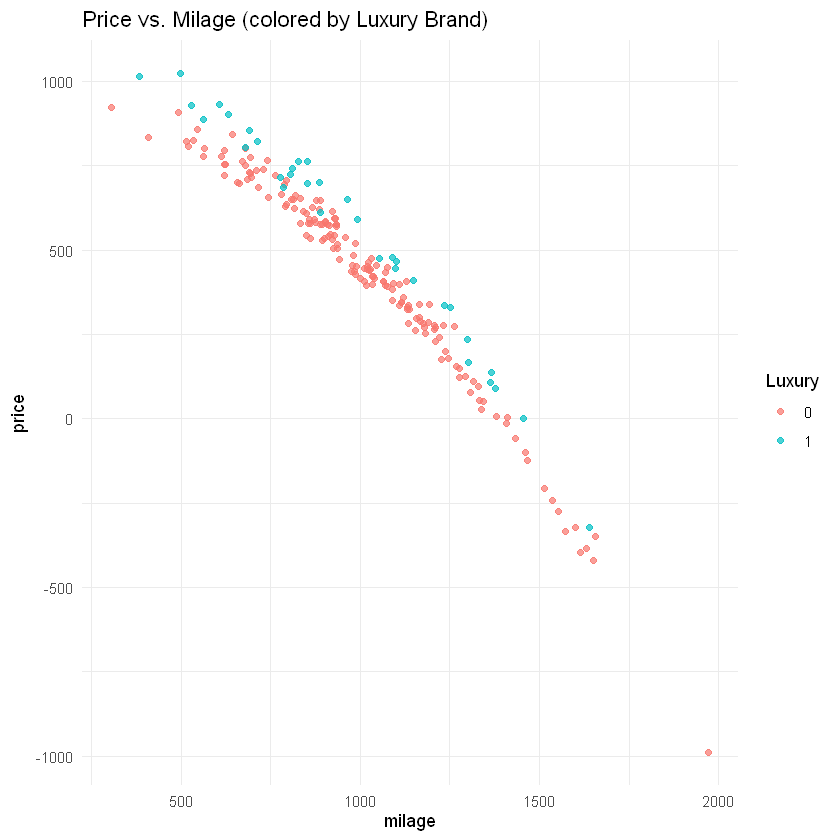

In [ ]:
# Summary statistics
summary(cars)

# A scatterplot matrix of all variables
pairs(cars, main = "Scatterplot Matrix of Simulated Variables")

# Price vs Milage colored by luxury brand
ggplot(cars, aes(x = milage, y = price, color = factor(luxury))) +
  geom_point(alpha = 0.7) +
  labs(title = "Price vs. Milage (colored by Luxury Brand)",
       color = "Luxury") +
  theme_minimal()





### 2) Misspecified Linear Model

We (incorrectly) omit the $\text{milage}^2$ term and include only a linear effect of milage:
$
\text{price}_i = \alpha_0 + \alpha_1\,\text{milage}_i + \alpha_2\,\text{years\_old}_i + \alpha_3\,\text{convertible}_i + \alpha_4\,\text{luxury}_i + u_i.
$

This induces functional form misspecification $\Rightarrow$ biased estimates. Specifically estimates of milage (-1.05) appear very different compared to the true parameter (-0.0005). This is caused by the efect of the linear parameter which is trying to "soak up" the true effect that is non-linear. Intercept is also biased (roughly 500 higher), it is also caused by the functional form misspecification. 

Since the other variables are generater without correlation to milage they are exogenous. This can be proven mathematically, since $\text{Bias}(\beta_j) = \gamma \cdot \pi_j$, where $\gamma$ is the effect of ommited variable (in this case $\text{milage}^2$), $j$ is the index of the other variables and $\pi_j$ is the slope from regressing the omitted variable on regressor $j$. We know that $\pi_j = 0$ and thus bias is zero $\Rightarrow$ those estimates are unbiased and consistent. We can see this visually since those estimates are very close to true value. The difference is caused by small sample size. 

To test this we can first check correlation between regressors and the omited variable. If the correlation is zero as sample size grows this indicates unbiased results. Moreover we did Ramsey Reset test to check functional form misspecification and the small p-value below indicates we can reject $H_0$: Correctly Specified with high confidence (more than 99\%)

In [17]:
model_wrong <- lm(price ~ milage + years_old + convertible + luxury, data = cars)
summary(model_wrong)

cor(cars$milage, cars$milage^2)      
cor(cars$years_old, cars$milage^2)   
cor(cars$convertible, cars$milage^2) 
cor(cars$luxury, cars$milage^2)
resettest(model_wrong, power = 2:3)


Call:
lm(formula = price ~ milage + years_old + convertible + luxury, 
    data = cars)

Residuals:
    Min      1Q  Median      3Q     Max 
-400.48  -14.46   15.99   35.48   73.31 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1509.35641   18.22953  82.797  < 2e-16 ***
milage        -1.04522    0.01507 -69.342  < 2e-16 ***
years_old     -5.86401    1.04802  -5.595 7.38e-08 ***
convertible   61.21950    9.34337   6.552 4.93e-10 ***
luxury        93.42512   11.26295   8.295 1.76e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 59.43 on 195 degrees of freedom
Multiple R-squared:  0.9646,	Adjusted R-squared:  0.9638 
F-statistic:  1327 on 4 and 195 DF,  p-value: < 2.2e-16


[1] 0.9819379

[1] 0.07004344

[1] -0.1413081

[1] -0.04953402


	RESET test

data:  model_wrong
RESET = 716.76, df1 = 2, df2 = 193, p-value < 2.2e-16


### 3) Correct Functional Specification

Now we estimated the true functional form with $\text{milage}^2$:
$
\text{price}_i = \alpha_0 + \beta_1\,\text{milage}_i^2 + \beta_2\,\text{years\_old}_i + \beta_3\,\text{convertible}_i + \beta_4\,\text{luxury}_i + \varepsilon_i.
$

We also test whether the estimated coefficients equal the true values via Wald tests: $1000, -0.0005, -5, 50, 100$. The Wald test has p-value of 31.5\%. This implies that we cannot reject null hypothesis with any meaningful confidence (for example $> 90\%$), and thus we cannot say that those estimates **are not** equal to the true values.

**We did use AI** when conducting the wald test in order to obtain optimal code

In [16]:
model_true <- lm(price ~ I(milage^2) + years_old + convertible + luxury, data = cars)
summary(model_true)

# Wald tests for equality to true parameters
lh_res <- car::linearHypothesis(
  model_true,
  c("(Intercept) = 1000",
    "I(milage^2) = -0.0005",
    "years_old = -5",
    "convertible = 50",
    "luxury = 100")
)
lh_res




Call:
lm(formula = price ~ I(milage^2) + years_old + convertible + 
    luxury, data = cars)

Residuals:
    Min      1Q  Median      3Q     Max 
-41.625  -9.810   0.211   9.937  39.366 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.002e+03  3.180e+00  315.03   <2e-16 ***
I(milage^2) -5.002e-04  1.752e-06 -285.54   <2e-16 ***
years_old   -5.373e+00  2.594e-01  -20.71   <2e-16 ***
convertible  4.909e+01  2.317e+00   21.19   <2e-16 ***
luxury       1.045e+02  2.784e+00   37.53   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 14.7 on 195 degrees of freedom
Multiple R-squared:  0.9978,	Adjusted R-squared:  0.9978 
F-statistic: 2.243e+04 on 4 and 195 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,200,43443.49,NA,NA,NA,NA
2,195,42157.81,5,1285.688,1.189384,0.3157863


### 4) Heteroskedasticity Scenario and Corrections

We now simulated a new outcome where the error term is proportional to milage:
$
\text{price}_i = 1000 - 0.0005\,\text{milage}_i^2 - 5\,\text{years\_old}_i + 50\,\text{convertible}_i + 100\,\text{luxury}_i + \text{milage}_i\ \cdot \varepsilon_i.
$



Since the multiplicative heteroskedasticity is proportional to mileage. OLS coefficients remain unbiased and consistent (exogeneity holds), but usual OLS standard errors are invalid and efficiency is lost. The B-P test has very low p-value thus we reject null hypothesis of homoskedasticity. With use of robust (HC1) SEs we fixed the inference with misspecified variance. Next we divided the whole model with $\frac{1}{\text{milage}}$, which is the true form of heteroskedasticity further improving SEs, but in proces we changed the interpetation of the intercept which is now $\frac{\text{intercept}}{\text{milage}}$, similarly ve divided all other variables including $y$ and we now only have linear effect of milage, thus our interpretation changes.

In [ ]:
# Multiplicative heteroskedasticity
epsilon2 <- rnorm(N, 0, 15)
price2 <- 1000 - 0.0005 * milage^2 - 5 * years_old + 50 * convertible + 100 * luxury + milage * epsilon2

cars2 <- data.frame(price2, milage, years_old, convertible, luxury)

# "True" structural regressors 
model_het <- lm(price2 ~ I(milage^2) + years_old + convertible + luxury, data = cars2)
summary(model_het)

# Breusch-Pagan test for heteroskedasticity
bp <- bptest(model_het)
bp

# Robust standard errors
robust_vcov <- vcovHC(model_het, type = "HC1")
robust_se <- sqrt(diag(robust_vcov))

# Coefficients with robust SEs
lmtest::coeftest(model_het, vcov = robust_vcov)

# Known-form correction: dividing both sides by milage
cars2 <- cars2 %>% mutate(
  price2_adj   = price2 / milage,
  milage2_adj  = (milage^2) / milage,   
  years_adj    = years_old / milage
)

model_corrected <- lm(price2_adj ~ milage2_adj + years_adj + convertible + luxury, data = cars2)
summary(model_corrected)




Call:
lm(formula = price2 ~ I(milage^2) + years_old + convertible + 
    luxury, data = cars2)

Residuals:
   Min     1Q Median     3Q    Max 
-58767  -7744    623   9595  59555 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  5.359e+03  3.348e+03   1.601   0.1110  
I(milage^2)  2.569e-04  1.844e-03   0.139   0.8893  
years_old   -5.964e+02  2.731e+02  -2.184   0.0302 *
convertible  1.836e+03  2.439e+03   0.753   0.4525  
luxury      -1.244e+03  2.931e+03  -0.425   0.6716  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 15480 on 195 degrees of freedom
Multiple R-squared:  0.02921,	Adjusted R-squared:  0.009297 
F-statistic: 1.467 on 4 and 195 DF,  p-value: 0.2138



	studentized Breusch-Pagan test

data:  model_het
BP = 37.088, df = 4, p-value = 1.728e-07



t test of coefficients:

               Estimate  Std. Error t value Pr(>|t|)  
(Intercept)  5.3593e+03  3.8160e+03  1.4044  0.16178  
I(milage^2)  2.5692e-04  2.9130e-03  0.0882  0.92981  
years_old   -5.9641e+02  2.7156e+02 -2.1963  0.02925 *
convertible  1.8359e+03  2.1942e+03  0.8367  0.40376  
luxury      -1.2442e+03  3.4768e+03 -0.3579  0.72083  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Call:
lm(formula = price2_adj ~ milage2_adj + years_adj + convertible + 
    luxury, data = cars2)

Residuals:
    Min      1Q  Median      3Q     Max 
-43.457  -8.863  -0.087   9.836  38.537 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  1.178e+01  5.745e+00   2.051   0.0416 *
milage2_adj -6.954e-03  4.199e-03  -1.656   0.0993 .
years_adj   -4.099e+02  2.202e+02  -1.861   0.0642 .
convertible  9.042e-01  2.280e+00   0.397   0.6921  
luxury      -1.120e+00  2.738e+00  -0.409   0.6828  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 14.47 on 195 degrees of freedom
Multiple R-squared:  0.02431,	Adjusted R-squared:  0.004293 
F-statistic: 1.215 on 4 and 195 DF,  p-value: 0.3059


### 5) Quantile Regression (τ = 0.05 to 0.95 by 0.05)

We estimated quantile regressions for the correctly specified model and plot how key coefficients vary across quantiles. This reveals distributional heterogeneity beyond the conditional mean. We can see that the estimates of different quantiles vary, for example for $\text{milage}^2$ variable, but those difference are rather small and insignificant. Nevertheless quantile regression did uncover more precise estimates of different part of the population, but again in this case not so significant differences.

,(Intercept),I(milage^2),years_old,convertible,luxury,tau
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,977.5517,-0.0005007882,-4.893971,45.13564,90.68729,0.05
2,979.2472,-0.0004983454,-5.138985,48.22828,108.28120,0.10
3,985.9332,-0.0004989380,-5.478099,50.12994,107.91111,0.15
4,986.8641,-0.0004993317,-5.378036,52.00613,106.61015,0.20
5,992.3923,-0.0005007132,-5.407758,49.08453,107.27943,0.25
6,995.8403,-0.0005014957,-5.471076,49.14202,105.99357,0.30


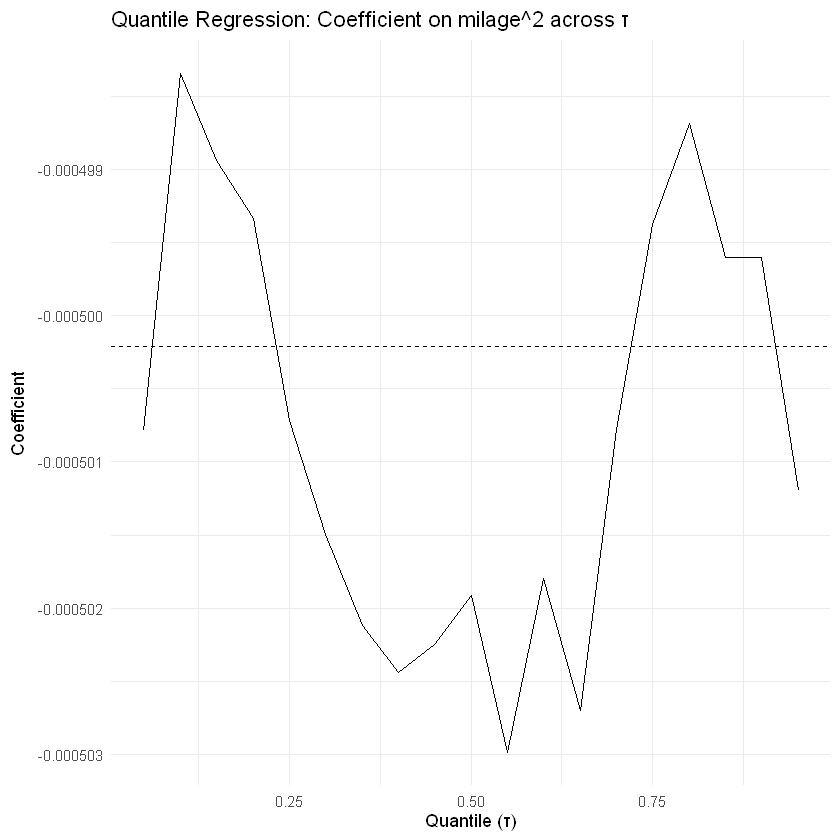

In [ ]:
taus <- seq(0.05, 0.95, by = 0.05)
qr_models <- lapply(taus, function(tau) {
  quantreg::rq(price ~ I(milage^2) + years_old + convertible + luxury, data = cars, tau = tau)
})

# Coefficients
coef_mat <- sapply(qr_models, coef)
coef_df <- as.data.frame(t(coef_mat))
coef_df$tau <- taus

head(coef_df)

# Plots
  ggplot(coef_df, aes(x = tau, y = `I(milage^2)`)) +
    geom_line() +
    geom_hline(yintercept = coef(model_true)["I(milage^2)"], linetype = "dashed") +
    labs(title = "Quantile Regression: Coefficient on milage^2 across τ",
        x = "Quantile (τ)", y = "Coefficient") +
    theme_minimal()




# Problem 2 — Vietnam Living Standards Survey (1997)
### Q1 — Data selection, summary, proportions, and basic graphs

'data.frame':	5999 obs. of  6 variables:
 $ lhhexp1 : num  10.1 10.3 10.9 10.3 10.5 ...
 $ lhhex12m: num  11.23 8.51 8.71 9.29 7.56 ...
 $ farm    : Factor w/ 2 levels "non farm","farm": 1 1 1 1 1 1 1 1 1 1 ...
 $ urban98 : Factor w/ 2 levels "Rural","Urban": 2 2 2 2 2 2 2 2 2 2 ...
 $ age     : int  68 57 42 72 73 66 73 46 50 45 ...
 $ sex     : int  2 2 1 2 2 2 2 1 1 1 ...
 - attr(*, "datalabel")= chr ""
 - attr(*, "time.stamp")= chr "19 Sep 2002 21:45"
 - attr(*, "formats")= chr [1:9] "%8.0g" "%8.0g" "%9.0g" "%9.0g" ...
 - attr(*, "types")= int [1:9] 98 105 102 102 98 108 102 102 102
 - attr(*, "val.labels")= chr [1:9] "" "" "" "loaiho" ...
 - attr(*, "var.labels")= chr [1:9] "Gender of HH.head (1:M;2:F)" "Age of household head" "schooling year of HH.head" "Type of HH (1:farm; 0:nonfarm)" ...
 - attr(*, "expansion.fields")=List of 3
  ..$ : chr [1:3] "_dta" "iis" "househol"
  ..$ : chr [1:3] "_dta" "strata" "commune"
  ..$ : chr [1:3] "_dta" "pweight" "wt"
 - attr(*, "version")= int

    lhhexp1          lhhex12m            farm       urban98          age       
 Min.   : 6.543   Min.   : 0.000   non farm:2561   Rural:4269   Min.   :16.00  
 1st Qu.: 8.920   1st Qu.: 5.273   farm    :3438   Urban:1730   1st Qu.:37.00  
 Median : 9.311   Median : 6.372                                Median :46.00  
 Mean   : 9.342   Mean   : 6.311                                Mean   :48.01  
 3rd Qu.: 9.759   3rd Qu.: 7.392                                3rd Qu.:58.00  
 Max.   :12.202   Max.   :12.363                                Max.   :95.00  
                  NA's   :993                                                  
      sex       
 Min.   :1.000  
 1st Qu.:1.000  
 Median :1.000  
 Mean   :1.271  
 3rd Qu.:2.000  
 Max.   :2.000  
                


        1         2 
0.7292882 0.2707118 


 non farm      farm 
0.4269045 0.5730955 


    Rural     Urban 
0.7116186 0.2883814 

,lhhexp1,lhhex12m,age
lhhexp1,1.00000000,0.2422273,-0.03740293
lhhex12m,0.24222730,1.0000000,0.11099332
age,-0.03740293,0.1109933,1.00000000


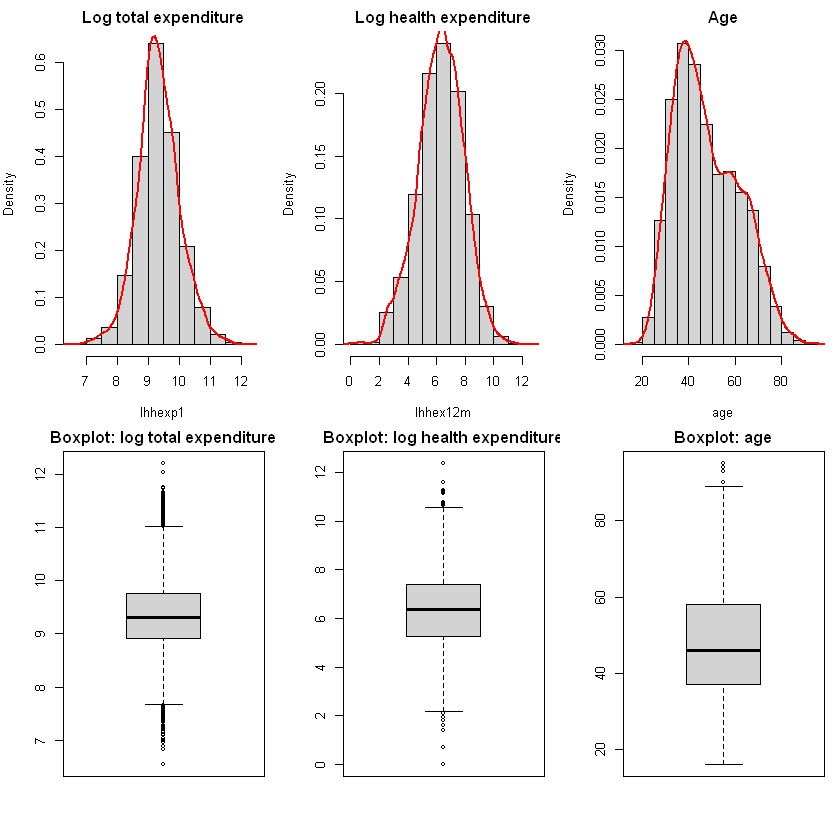

In [1]:
load("./problem_2_dataset.Rdata")
# variables 
q_data <- q_data |> dplyr::select(lhhexp1, lhhex12m, farm, urban98, age, sex)

# Structure and summary
str(q_data)
summary(q_data)

# Proportions for categorical variables
prop.table(table(q_data$sex))
prop.table(table(q_data$farm))
prop.table(table(q_data$urban98))

# Continuous variables: histograms with kernel density overlays
par(mfrow = c(2,3), mar = c(4,4,2,1))

hist(q_data$lhhexp1, probability = TRUE, main = "Log total expenditure",
     xlab = "lhhexp1", col = "lightgray")
lines(density(q_data$lhhexp1, na.rm = TRUE), col = "red", lwd = 2)

hist(q_data$lhhex12m, probability=TRUE, main="Log health expenditure",
     xlab="lhhex12m", col="lightgray")
lines(density(q_data$lhhex12m, na.rm=TRUE), col="red", lwd=2)

hist(q_data$age, probability=TRUE, main="Age", xlab="age", col="lightgray")
lines(density(q_data$age, na.rm=TRUE), col="red", lwd=2)

boxplot(q_data$lhhexp1, main = "Boxplot: log total expenditure")
boxplot(q_data$lhhex12m, main="Boxplot: log health expenditure")
boxplot(q_data$age, main="Boxplot: age")

par(mfrow = c(1,1))

# Simple correlation among continuous vars
cor(q_data[, c("lhhexp1", "lhhex12m", "age")], use="complete.obs")


  
> - Majority of observations are rural and male (see proportions).  
> - `lhhex12m` contains missing values that should be kept in mind for regression sample size.  
> - Expenditure variables look approximately normal; `age` is slightly right-skewed.  
> - Boxplots suggest possible outliers in expenditures.

### Q2 — OLS model and interpretation

In [3]:
# Recode sex to factor with labels
q_data_adj <- q_data |>
  dplyr::mutate(sex = dplyr::case_when(
    sex == 1 ~ "male",
    sex == 2 ~ "female"
  )) |>
  dplyr::mutate(sex = factor(sex, levels = c("male","female")))

# OLS
model_1 <- lm(lhhex12m ~ lhhexp1 + farm + urban98 + age + sex, data = q_data_adj)
summary(model_1)


Call:
lm(formula = lhhex12m ~ lhhexp1 + farm + urban98 + age + sex, 
    data = q_data_adj)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.5891 -0.9441  0.1066  1.0450  5.7723 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.033299   0.364076  -2.838 0.004556 ** 
lhhexp1       0.715841   0.036964  19.366  < 2e-16 ***
farmfarm      0.034002   0.055252   0.615 0.538312    
urban98Urban -0.385190   0.062356  -6.177 7.04e-10 ***
age           0.014186   0.001595   8.894  < 2e-16 ***
sexfemale     0.176317   0.051252   3.440 0.000586 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.526 on 5000 degrees of freedom
  (993 observations deleted due to missingness)
Multiple R-squared:  0.08373,	Adjusted R-squared:  0.08281 
F-statistic: 91.38 on 5 and 5000 DF,  p-value: < 2.2e-16


- `lhhexp1` (total expenditure): positive and significant — higher total spending is associated with higher health spending.  
- `age`: positive and significant .  
- `urban98`: negative and significant — may reflect access/cost differences.  
- `farm`: insignificant.  
- `sex` (female vs. male baseline): positive and significant.  
- Adjusted R² is low ⇒ health spending variation is largely unexplained by these covariates alone.

### Q3 — Quantile regression (τ = 0.05 … 0.95 by 0.10)
### + Q4

Warning message in summary.rq(xi, U = U, ...):
"7 non-positive fis"


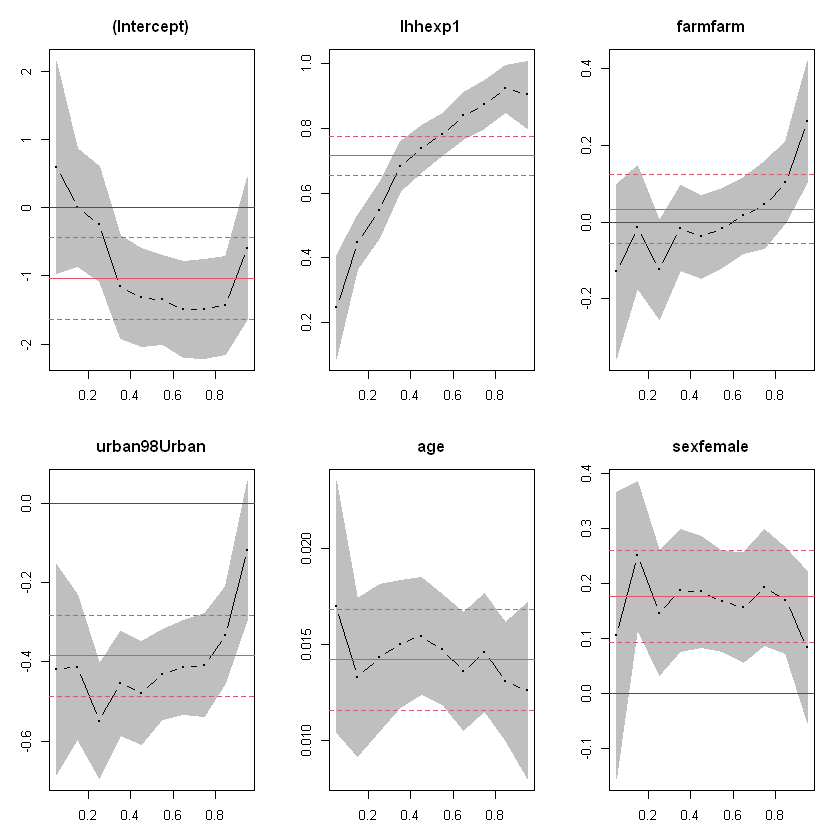

In [7]:
# quantile regressions across a grid of taus
taus <- seq(0.05, 0.95, by = 0.10)
qr_model_1 <- rq(lhhex12m ~ lhhexp1 + farm + urban98 + age + sex,
                 data = q_data_adj, tau = taus)
summary_qr_model_1 <- summary(qr_model_1)

# summary plots (coefficients vs quantiles with OLS line)
par(mfrow = c(2,3))
plot(summary_qr_model_1, mfrow = c(2, 3))
par(mfrow = c(1,1))


### Interpretation of Quantile Regression Results

- The **intercept** is negative for most of the distribution but increases again for the lowest and highest quantiles, suggesting that baseline log health expenditure varies non-linearly across the conditional distribution.  
- The coefficient for **`lhhexp1` (log total expenditure)** rises steadily from about 0.2 at the 5th quantile to nearly 1.0 at the 95th quantile, indicating that wealthier households allocate a progressively larger share of spending to health as total expenditure increases.  
- The **`farm`** dummy fluctuates around zero, becoming slightly positive in higher quantiles, implying that living on a farm increases health expenditure only among the highest-spending households.  
- The **`urban98`** effect is consistently negative across almost all quantiles, meaning that households in urban areas tend to spend less on health than rural ones, conditional on income and other factors.  
- The **`age`** effect remains positive and stable, showing that age is associated with higher health expenditure throughout the distribution, although the magnitude is relatively small.  
- For **`sex (female)`**, coefficients are mostly positive, suggesting that females generally have higher health expenditure, but the wide confidence bands imply the effect is not uniform or statistically strong across quantiles.  

Overall, these results reveal **heterogeneity** in the determinants of health expenditure:  
while income elasticity (`lhhexp1`) clearly increases with expenditure level, other socioeconomic variables remain relatively stable or weakly determined across quantiles.

### Q5 — OLS-by-deciles vs Quantile Regression (single regressor)

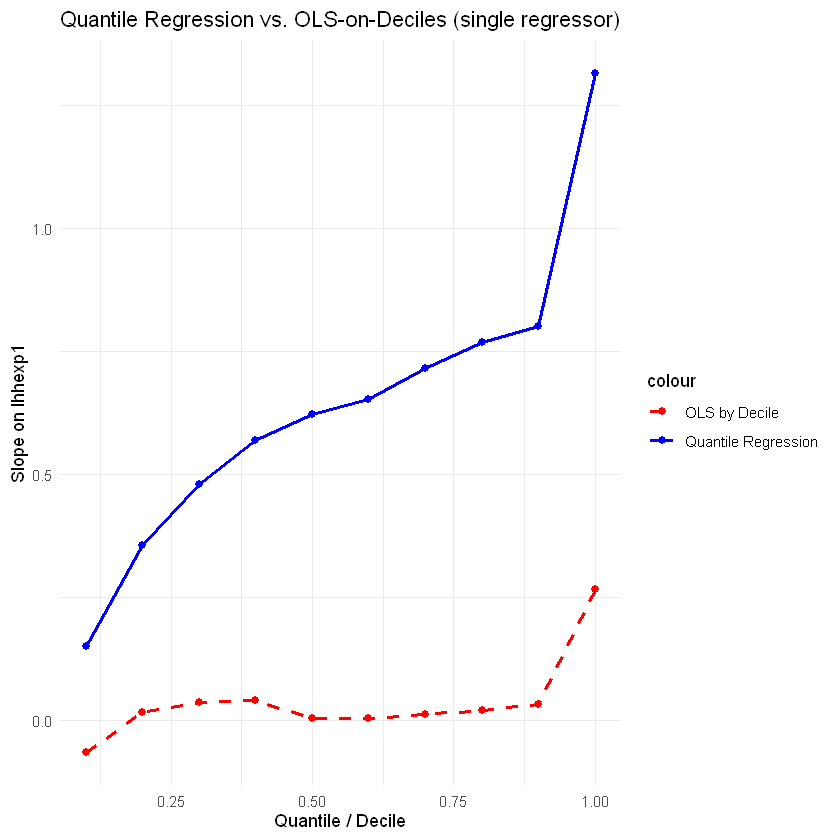

In [9]:
# data for single-regressor comparison
original_data <- q_data |> dplyr::select(lhhexp1, lhhex12m)

taus2 <- seq(0.1, 1, by = 0.1)

# QR slopes by quantile for model with intercept + lhhexp1
qr_betas <- sapply(taus2, function(tau) {
  coef(rq(lhhex12m ~ lhhexp1, data = original_data, tau = tau))
})
qr_betas <- t(qr_betas)
colnames(qr_betas) <- c("Intercept_qr", "Slope_qr")
qr_betas <- as.data.frame(qr_betas)
qr_betas$tau <- taus2

# OLS by decile of response
ols_data <- q_data |> dplyr::mutate(decile = dplyr::ntile(lhhex12m, 10))
ols_betas <- data.frame()
for (i in 1:10) {
  decile_data <- dplyr::filter(ols_data, decile == i)
  model <- lm(lhhex12m ~ lhhexp1, data = decile_data)
  coefs <- coef(model)
  ols_betas <- rbind(ols_betas,
                     data.frame(decile = i,
                                Intercept_ols = coefs[1],
                                Slope_ols = coefs[2]))
}

# Visual comparison
library(ggplot2)
comparison <- ggplot() +
  geom_line(data = qr_betas, aes(x = tau, y = Slope_qr, color = "Quantile Regression"), linewidth = 1.1) +
  geom_point(data = qr_betas, aes(x = tau, y = Slope_qr, color = "Quantile Regression"), size = 2) +
  geom_line(data = ols_betas, aes(x = decile/10, y = Slope_ols, color = "OLS by Decile"),
            linetype = "dashed", linewidth = 1) +
  geom_point(data = ols_betas, aes(x = decile/10, y = Slope_ols, color = "OLS by Decile"), size = 2) +
  labs(x = "Quantile / Decile", y = "Slope on lhhexp1",
       title = "Quantile Regression vs. OLS-on-Deciles (single regressor)") +
  scale_color_manual(values = c("Quantile Regression" = "blue", "OLS by Decile" = "red")) +
  theme_minimal()
comparison


OLS-on-deciles runs **separate** regressions on subsets and ignores the full conditional distribution, while QR uses **all** data and targets conditional quantiles. The two sets of slopes generally differ; QR is the correct tool for conditional quantile effects.

## Problem 3: MLE 
### 1) Generating Data Samples

We generated random samples from a chi-squared distribution with $k = 8$ degrees of freedom, using sample sizes $n = 5, 10, 20, 40, 100, 200, 500, 1000, 2000$.

For each sample, we computed descriptive statistics and plotted histograms with the theoretical chi-squared density

$$
f(x) = \frac{1}{2^{k/2}\Gamma(k/2)}x^{k/2 - 1}e^{-x/2}.
$$

The visual comparison shows that for small $n$, the empirical distributions are irregular and deviate from the theoretical chi-squared shape, while for large $n$, they become smoother and closely match the theoretical curve, illustrating the Law of Large Numbers.



  n_label     mean       sd       min       q1   median        q3      max
1     n=5 8.341436 5.191962 2.1055607 5.059959 7.492108 12.161641 14.88791
2    n=10 7.885401 3.598191 2.0288770 5.661100 8.495446 10.029937 12.68277
3    n=20 6.413251 2.612193 2.1114387 4.928903 6.321861  7.123200 12.24937
4    n=40 7.077079 3.366370 2.4044153 4.553400 6.908670  8.498360 17.35534
5   n=100 8.041959 3.900892 0.9707359 5.294277 7.307695  9.880059 20.80013
6   n=200 7.806679 3.794252 1.1501435 4.996562 7.374034 10.078777 24.68734
7   n=500 7.769699 3.812796 1.1720177 4.977334 7.265764  9.994590 24.82297
8  n=1000 7.944449 4.009040 0.9660254 5.019731 7.289491 10.110876 28.82998
9  n=2000 8.019619 3.969595 0.7425827 5.143894 7.367688 10.026316 35.05462


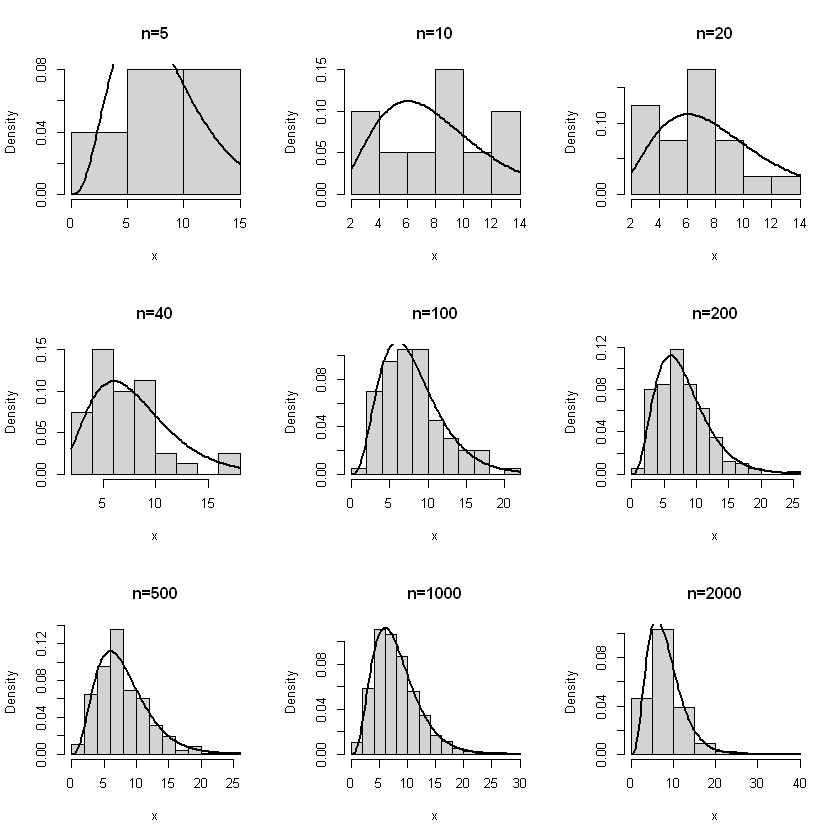

In [ ]:
set.seed(123)

# Parameters
k <- 8  
ns <- c(5, 10, 20, 40, 100, 200, 500, 1000, 2000)

# Generate data
samples_list <- lapply(ns, function(n) rchisq(n, df = k))
names(samples_list) <- paste0("n=", ns)

# Descriptive statistics
desc_tbl <- do.call(rbind, lapply(names(samples_list), function(nm) {
v <- samples_list[[nm]]
qs <- quantile(v, probs = c(0, 0.25, 0.5, 0.75, 1))
data.frame(
n_label = nm,
mean = mean(v),
sd = sd(v),
min = qs[1],
q1 = qs[2],
median = qs[3],
q3 = qs[4],
max = qs[5]
)
}))
row.names(desc_tbl) <- NULL
print(desc_tbl)

# Visualization
par(mfrow = c(3, 3))
for (nm in names(samples_list)) {
x <- samples_list[[nm]]
hist(x, probability = TRUE, main = nm, xlab = "x")
curve(dchisq(x, df = k), add = TRUE, lwd = 2)
}
par(mfrow = c(1, 1))